# Introduction

This Notebook will focus on deep learning section of uber eats menu price prediction project

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ahmedshahriar/restaurant-menu-pricing/blob/main/notebooks/uber-eats-deep-learning.ipynb)    [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ahmedshahriar/restaurant-menu-pricing/blob/main/notebooks/uber-eats-deep-learning.ipynb)    [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github.com/ahmedshahriar/restaurant-menu-pricing/blob/main/notebooks/uber-eats-deep-learning.ipynb)


Dataset -

[Uber Eats USA Data](https://www.kaggle.com/datasets/ahmedshahriarsakib/uber-eats-usa-restaurants-menus)

# Libraries

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# https://developer.apple.com/forums/thread/721619
# tensorflow-macos==2.9 and tensorflow-metal==0.5.0

SEED = 33
tf.random.set_seed(SEED)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [ ]:
df_embed = pd.read_csv("datasets/recipe-BERT-embedding.csv")
df_embed.drop(columns=["city"], axis=1, inplace=True)

In [ ]:
df_embed.head()

In [112]:
df_embed[["price"]].describe().style.format("{:.6}")

,price
count,42710.0
mean,10.5137
std,3.02306
min,2.0
25%,8.33
50%,10.0
75%,12.49
max,19.09


# Data Preparation

In [44]:
df = df_embed.copy()

# train test split
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in strat_split.split(df, df["category"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# train Dataset
X_train = strat_train_set.loc[:, strat_train_set.columns != "price"].copy()
y_train = strat_train_set["price"].copy()

# test dataset
X_test = strat_test_set.loc[:, strat_test_set.columns != "price"].copy()
y_test = strat_test_set["price"].values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((34168, 773), (34168,), (8542, 773), (8542,))

# Feature Encoding 

In [45]:
numerical_columns = ["density", "cost_of_living_index"]
scaler = MinMaxScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns].values)
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns].values)

categorical_columns = ["category", "price_range", "state_id"]
encoder = OneHotEncoder(handle_unknown="ignore")

# Fit and transform the training data
X_train_encoded = encoder.fit_transform(X_train[categorical_columns].values)
X_train_encoded = X_train_encoded.toarray()

# # Transform the test data using the encoder fitted on the training data
X_test_encoded = encoder.transform(X_test[categorical_columns].values)
X_test_encoded = X_test_encoded.toarray()


# # Assign the one-hot encoded data back to the DataFrame
X_train_encoded_df = pd.DataFrame(
    X_train_encoded, columns=encoder.get_feature_names_out(input_features=categorical_columns)
)
X_test_encoded_df = pd.DataFrame(
    X_test_encoded, columns=encoder.get_feature_names_out(input_features=categorical_columns)
)

# Reset the index of original DataFrames
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Update the original DataFrame with the encoded data
X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)

# Drop the original categorical columns
X_train.drop(columns=categorical_columns, inplace=True)
X_test.drop(columns=categorical_columns, inplace=True)

In [40]:
X_train

,density,cost_of_living_index,0,1,2,3,4,5,6,7,...,category_Sandwiches,category_Wraps,price_range_cheap,price_range_expensive,price_range_moderate,state_id_Texas,state_id_Utah,state_id_Virginia,state_id_Washington,state_id_Wisconsin
0,0.054939,0.000000,0.109449,0.100948,-0.453962,-0.033093,0.127764,0.003882,0.203345,0.458807,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.155465,0.108478,0.027007,0.021951,-0.353490,0.035018,0.185091,0.026994,0.182757,0.492029,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.229982,0.775915,-0.023388,-0.075879,-0.332040,0.093661,0.286806,0.143533,0.082484,0.691186,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.809468,1.000000,-0.007522,-0.058483,-0.223920,0.026183,0.234260,0.061902,0.096018,0.453816,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.222677,0.430829,0.036016,0.098676,-0.301412,0.071191,0.295440,0.016209,0.055424,0.682134,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34163,0.229982,0.775915,-0.113228,-0.164122,-0.242380,-0.027962,0.220986,0.026403,0.047389,0.412478,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
34164,0.488019,0.050289,0.007229,0.114634,-0.448966,0.078461,0.002450,-0.130147,0.177607,0.393421,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
34165,0.222677,0.430829,0.102940,-0.041838,-0.414583,-0.019902,0.308787,-0.081890,-0.075241,0.578608,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34166,0.109001,0.318882,0.006835,0.025535,-0.315930,0.108072,0.159261,-0.054129,0.126179,0.531818,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [106]:
# plot accuracy and loss
def plot_history(history):
    mse_score = history.history["mse"]
    val_mse = history.history["val_mse"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(mse_score) + 1)
    plt.plot(epochs, mse_score, "bo", label="Training MSE")
    plt.plot(epochs, val_mse, "b", label="Validation MSE")
    plt.xlabel("# Epochs")
    plt.ylabel("Mean Squared Error (MSE)")
    # plt.title('Training and validation MSE')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    # plt.title('Training and validation loss')
    plt.xlabel("# Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


# plot model architecture
def plot_model(model):
    model.summary()
    return tf.keras.utils.plot_model(
        model,
        to_file="model-NN.png",
        show_shapes=True,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=True,
        dpi=96,
        layer_range=None,
    )

## Hyperparameter Tuning

The optimum hyperparameter values - 

| Hyperparameter                   | Value     |
|----------------------------------|-----------|
| Learning Rate (Adam)             | 0.0001    |
| Dropout Rate                     | 0.1       |
| # of  layers                     | 3         |
| # of Neuron/Units (Hidden Layer) | 256,128,64|
| Batch Size                       | 32        |
| Number of Epochs                 | 30        |
| Regularizers (L2)                | L2(0.0005)|
| Hidden Layer Activation          | ReLU      |

# Model 

In [94]:
def build_model_1():
    model = Sequential()
    model.add(Dense(256, activation="relu", input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.0005)))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.0005)))
    model.add(BatchNormalization())
    model.add(Dense(1))

    model.compile(
        loss="mean_squared_error", metrics=["mse", RootMeanSquaredError(), "mae"], optimizer=Adam(learning_rate=0.0001)
    )
    return model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 256)               200192    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_21 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_22 (Bat  (None, 128)              512       
 chNormalization)                                     

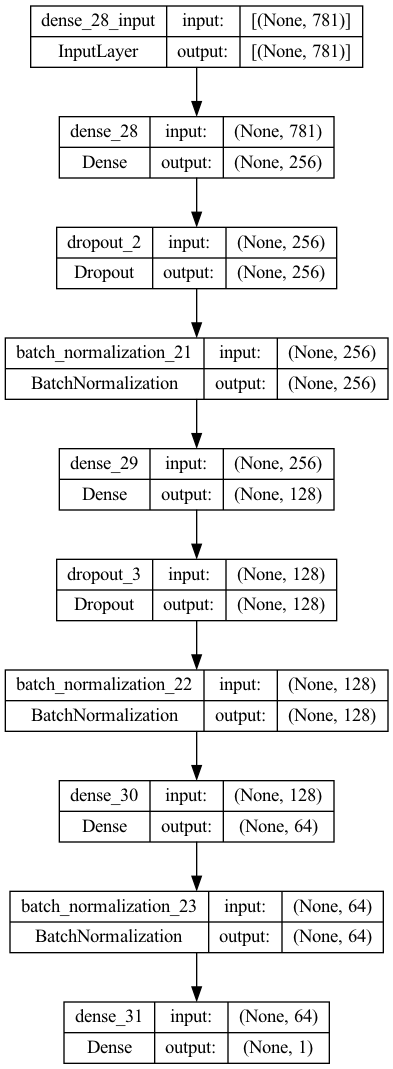

In [95]:
model_1 = build_model_1()
plot_model(model_1)

## Training (Single Pass)

Training on whole train data

In [96]:
%%time

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
callback_list = [early_stopping, reduce_lr]

# with tf.device("/CPU:0"):
history_nn = model_1.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,  # 64
    validation_split=0.2,  # since the data dimension is big
    verbose=1,
    shuffle=True,
    callbacks=callback_list,
)

Epoch 1/30


2023-07-31 20:13:50.883596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


855/855 [==============================] - ETA: 0s - loss: 108.0767 - mse: 107.9522 - root_mean_squared_error: 10.3900 - mae: 9.9790

2023-07-31 20:14:06.361144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


855/855 [==============================] - 17s 18ms/step - loss: 108.0767 - mse: 107.9522 - root_mean_squared_error: 10.3900 - mae: 9.9790 - val_loss: 91.9750 - val_mse: 91.8521 - val_root_mean_squared_error: 9.5839 - val_mae: 9.1746 - lr: 1.0000e-04
Epoch 2/30
855/855 [==============================] - 15s 18ms/step - loss: 74.0681 - mse: 73.9460 - root_mean_squared_error: 8.5992 - mae: 8.0972 - val_loss: 50.1702 - val_mse: 50.0486 - val_root_mean_squared_error: 7.0745 - val_mae: 6.5310 - lr: 1.0000e-04
Epoch 3/30
855/855 [==============================] - 14s 17ms/step - loss: 35.8619 - mse: 35.7406 - root_mean_squared_error: 5.9783 - mae: 5.2628 - val_loss: 16.9822 - val_mse: 16.8612 - val_root_mean_squared_error: 4.1062 - val_mae: 3.3675 - lr: 1.0000e-04
Epoch 4/30
855/855 [==============================] - 15s 18ms/step - loss: 13.9916 - mse: 13.8710 - root_mean_squared_error: 3.7244 - mae: 2.9879 - val_loss: 8.7940 - val_mse: 8.6737 - val_root_mean_squared_error: 2.9451 - val_mae

## Training Evaluation


Not overfitting

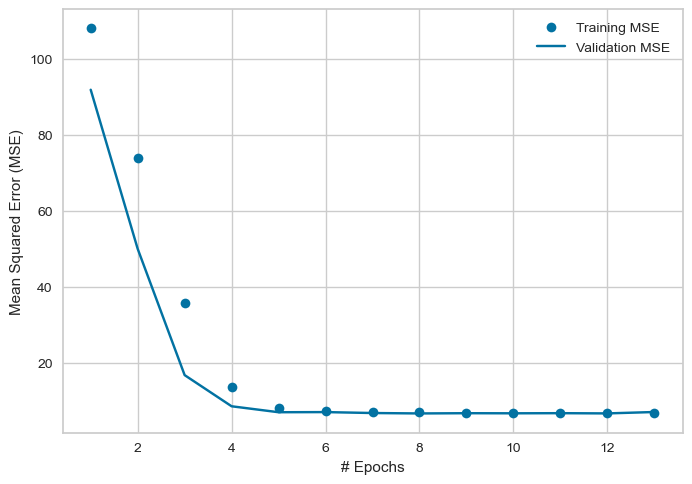

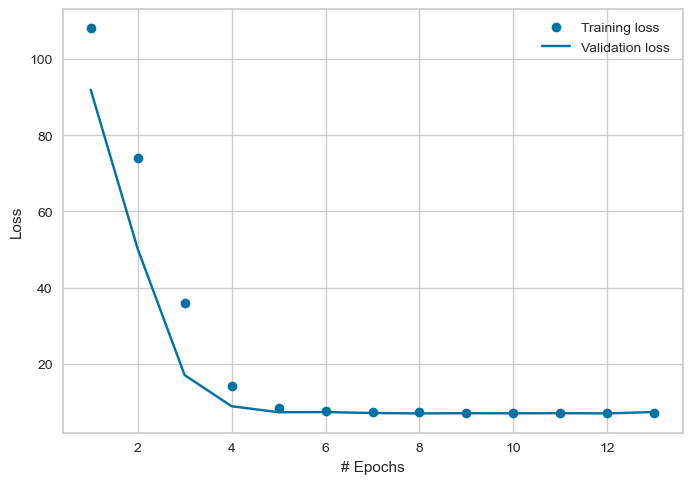

In [107]:
plot_history(history_nn)

## Cross Validation (5-Fold)

In [98]:
estimator = KerasRegressor(
    build_fn=build_model_1,
    epochs=30,
    batch_size=32,
    verbose=0,
    shuffle=True,
    callbacks=callback_list,
    validation_split=0.2,
)


kfold = KFold(n_splits=5)
scores = cross_val_score(estimator, X_train, y_train, cv=kfold, n_jobs=-1)  # all cpus
reg_rmse_score = np.sqrt(-scores)  # Mean RMSE

print(f"cross-validation score - mean  : {reg_rmse_score.mean():.3f} std: ({np.std(scores):.3f})")

/var/folders/xj/74j94j9j25b1l8s0pfpvzycm0000gn/T/ipykernel_83129/3966915816.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator= KerasRegressor(build_fn=build_model_1,


INFO:tensorflow:Assets written to: ram://86ad26e0-f3c3-4358-bc28-ea89d6206b63/assets
INFO:tensorflow:Assets written to: ram://7d964c1c-2e7f-4949-aa6f-27f40f4d3dd8/assets
INFO:tensorflow:Assets written to: ram://7ae116c8-31ec-42ea-9b37-d8b4cbf0b60b/assets
INFO:tensorflow:Assets written to: ram://95922bde-611f-45f6-9bb6-81a197edaa07/assets
INFO:tensorflow:Assets written to: ram://42d50ef0-19d6-462f-b5ba-a0feb53f7053/assets
INFO:tensorflow:Assets written to: ram://d902f8c2-7240-4e23-b168-f1f457487338/assets
INFO:tensorflow:Assets written to: ram://00f62673-4aa7-41e1-ad31-7a308269bf72/assets
INFO:tensorflow:Assets written to: ram://75c79e05-400f-4174-8872-aa6a60c9da6a/assets
INFO:tensorflow:Assets written to: ram://ba243f96-16f1-441a-9c3c-995d7ffacede/assets
INFO:tensorflow:Assets written to: ram://44ce0506-3073-4ed4-ba62-4c4ffe173a17/assets
INFO:tensorflow:Assets written to: ram://114bca56-6bb9-45bb-baa1-1d2a37c0a320/assets
INFO:tensorflow:Assets written to: ram://01f4da45-43e8-4955-9e6d-

2023-07-31 20:24:12.035656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-31 20:24:12.035842: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
INFO:tensorflow:Assets written to: ram://ed6de419-6b0c-4c16-98bd-57e19f58355a/assets
Metal device set to: Apple M1 Pro
INFO:tensorflow:Assets written to: ram://1adb5cfe-a900-4c73-9082-1aaba1478e83/assets


2023-07-31 20:24:13.720453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-31 20:24:13.720602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


INFO:tensorflow:Assets written to: ram://aa6d5a2a-49e2-4b99-9ee5-15bee1695e44/assets
INFO:tensorflow:Assets written to: ram://84496ada-589d-4911-b0a7-5587f14766d5/assets
INFO:tensorflow:Assets written to: ram://82d9dbc0-4c26-47a9-bef2-f51c285e2bbf/assets


2023-07-31 20:24:16.927534: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Pro
INFO:tensorflow:Assets written to: ram://32719370-201d-4f4e-b4c4-a7c14c5cf2a7/assets


2023-07-31 20:24:17.175362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-31 20:24:17.175498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-31 20:24:17.383735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-31 20:24:19.298356: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


INFO:tensorflow:Assets written to: ram://65c3a4ee-957c-4b50-889f-c2ebc1895ca6/assets


2023-07-31 20:24:20.254293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://76b4ed0d-b9e5-4a90-8f30-7aec1d2e5084/assets
Metal device set to: Apple M1 Pro


2023-07-31 20:24:21.646528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-31 20:24:21.648047: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-31 20:24:24.183814: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-31 20:24:24.597100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1 Pro


2023-07-31 20:24:25.222848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-31 20:24:25.222960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-31 20:24:26.947641: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-31 20:24:27.506177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-31 20:24:30.534755: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-31 20:24:30.948952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_r

cross-validation score - mean  : 2.624 std: (0.129)


## Test Evaluation

In [99]:
# model evaluation
print(f"Train MSE: {model_1.evaluate(X_train, y_train)}")
print(f"Test MSE: {model_1.evaluate(X_test, y_test)}")

1068/1068 [==============================] - 14s 13ms/step - loss: 6.9518 - mse: 6.8384 - root_mean_squared_error: 2.6150 - mae: 2.0673
Train MSE: [6.951831340789795, 6.838397979736328, 2.6150331497192383, 2.067300319671631]


2023-07-31 20:32:21.099285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


267/267 [==============================] - 6s 20ms/step - loss: 7.2895 - mse: 7.1757 - root_mean_squared_error: 2.6788 - mae: 2.1087
Test MSE: [7.289473056793213, 7.175709247589111, 2.678813934326172, 2.1086509227752686]

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [103]:
y_pred = model_1.predict(X_test)
print("\nTest Scores: \n")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
print(f"R^2: {r2_score(y_test, y_pred):.4f}")

 12/267 [>.............................] - ETA: 1s 

2023-07-31 22:54:39.660739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


267/267 [==============================] - 1s 4ms/step

Test Scores: 

MAE: 2.1087
MSE: 7.1760
RMSE: 2.6788
R^2: 0.2240
